
=== Fetching Beam Energies from MDSplus ===
Shot 112209: 2.35 kJ | 16.66 kV | Beam on: 0.461s - 0.471s
Shot 112210: 2.78 kJ | 16.56 kV | Beam on: 0.463s - 0.473s
Shot 112211: 2.82 kJ | 16.59 kV | Beam on: 0.463s - 0.473s
Shot 112212: 2.81 kJ | 16.64 kV | Beam on: 0.466s - 0.476s
Shot 112213: 2.86 kJ | 16.62 kV | Beam on: 0.466s - 0.476s
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.i_hvps
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.v_hvps
Shot 112245: No data
Shot 112246: 2.05 kJ | 16.35 kV | Beam on: 0.458s - 0.463s
Shot 112247: 0.05 kJ | 16.95 kV | Beam on: 0.458s - 0.463s
Shot 112248: No data
Shot 112249: 2.21 kJ | 16.39 kV | Beam on: 0.458s - 0.463s
Shot 112250: No data
Shot 112251: 1.99 kJ | 16.44 kV | Beam on: 0.458s - 0.463s
Shot 112252: 0.01 kJ | 5.71 kV | Beam on: 0.458s - 0.458s
Shot 112253: 1.83 kJ | 16.51 kV | Beam on: 0.458s - 0.463s
Shot 112254: 1.98 kJ | 16.45 kV | Beam on: 0.458s - 0.463s
Shot 112255: 1.85 kJ 

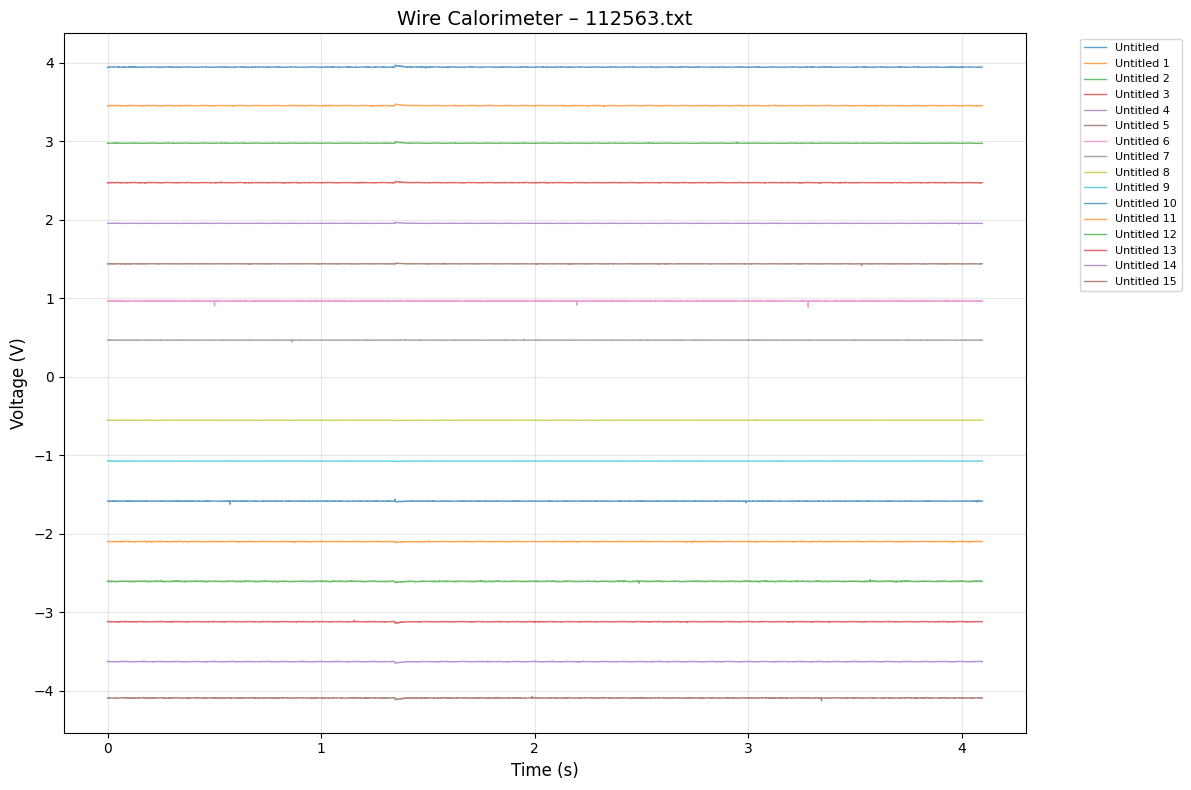

In [1]:
# NBI Wire Calorimeter Analysis
# H. Gajani

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/hgajani/LTXb-py-main/LTXb-py-main')
from bills_LTX_MDSplus_toolbox import get_tree_conn, get_data
import MDSplus as mds

# Wire properties
WIRE_CURRENT = 0.7  # Amps
TCR = 0.0045  # Tungsten temp coefficient

def get_avg_beam_power(shot, v_thresh=5000.0):
    """Fetch total beam energy from MDSplus during beam-on period."""
    try:
        if shot > 200000:
            treename = 'ltx_nbi'
            prefix = ''
        else:
            treename = 'ltx_b'
            prefix = '.oper_diags.ltx_nbi'
        
        tree = get_tree_conn(shot, treename=treename)
        (ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
        (tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')
        
        ib = np.interp(tv, ti, ib)
        pb = ib * vb / 1000.0  # kW
        
        mask = vb > v_thresh
        if np.any(mask):
            # Integrate power over time to get total energy
            tv_beam = tv[mask]
            pb_beam = pb[mask]
            vb_beam = vb[mask]
            total_energy = np.trapz(pb_beam, tv_beam)  # kJ (kW * s)
            beam_on_time = tv_beam[0]   # Time when beam turns on
            beam_off_time = tv_beam[-1]  # Time when beam turns off
            avg_beam_voltage = np.mean(vb_beam) / 1000.0  # Convert to kV
            return total_energy, beam_on_time, beam_off_time, avg_beam_voltage
        else:
            return np.nan, np.nan, np.nan, np.nan
            
    except (mds.mdsExceptions.TreeNODATA, Exception) as e:
        print(f'Warning: Could not fetch beam power for shot {shot}: {e}')
        return np.nan, np.nan, np.nan, np.nan

# Shot list
shot_list = [
    112209, 112210, 112211, 112212, 112213,

    112245, 112246, 112247, 112248, 112249, 112250,
    112251, 112252, 112253, 112254, 112255, 112256, 112257, 112258, 112259, 112260,
    112261, 112262, 112263, 112264, 112265, 112266, 112267, 112268, 112269, 112270,
    112271, 112272,

    112359, 112360, 112361, 112362, 112364,
    112393, 112394, 112395, 112396, 112397, 112398, 112399, 112400, 112401, 112402,
    112403, 112404, 112405, 112406, 112407, 112408, 112409, 112410, 112411, 112412,
    112413, 112414, 112415, 112416, 112417, 112418, 112419, 112420, 112421, 112422,
    112423, 112424, 112425, 112426, 112427, 112428, 112429, 112430, 112431, 112432,
    112433, 112434, 112435,
    112469, 112470, 112471, 112472, 112473, 112474, 112475, 112477, 112478, 112479,
    112480, 112481, 112482, 112483, 112484, 112485,
    112524, 112525, 112526, 112527, 112528, 112529, 112530, 112531, 112532, 112533,
    112534, 112535, 112536, 112537, 112538, 112539, 112540, 112541, 112542, 112543,
    112544, 112545, 112546, 112547, 112548, 112549, 112550, 112551, 112552, 112553,
    112554, 112555, 112556, 112557, 112558, 112559, 112560, 112561, 112562, 112563
]



base_path = Path("/p/ltxdata/NBI/WCAL")
file_list = [base_path / f"{shot}.txt" for shot in shot_list]

def find_data_start(path: Path) -> int:
    """Find where actual data starts in LVM file."""
    with open(path, "r", errors="ignore") as f:
        end = -1
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end = i
    return end + 1

def load_lvm(path: Path):
    """Load LVM file into dataframe."""
    start_row = find_data_start(path)
    df = pd.read_csv(path, sep="\t", skiprows=start_row, engine="python")
    df = df.dropna(axis=1, how="all").reset_index(drop=True)
    df["Time (s)"] = df.index * 1e-3  # 1 kHz sampling
    for c in df.columns:
        if c not in ["Time (s)", "Comment"]:
            df[c] = pd.to_numeric(df[c])
    return df

#load all datasets
datasets = {f.name: load_lvm(f) for f in file_list}
time_col = "Time (s)"

#building a table to manually confirm data
def build_power_table(df, shot_name, beam_energy_kj):
    channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"] and "16" not in c]
    rows = []

    for idx, col in enumerate(channel_cols):
        y = df[col].values
        
        # V_1: 2 seconds of data at t=0 (indices 0 to 2000)
        v1_start = 0
        v1_end = 2000
        V_1 = np.mean(y[v1_start:v1_end])
        R_1 = V_1 / WIRE_CURRENT
        
        # V_2: 2 seconds of data at t=1.8s (index 1800 to 3800, since 1.8s * 1000 = 1800)
        v2_start = 1800
        v2_end = v2_start + 2000
        V_2 = np.mean(y[v2_start:v2_end])
        R_2 = V_2 / WIRE_CURRENT

        # ΔR and ΔT
        delta_R = R_2 - R_1
        delta_T = delta_R / (R_1 * TCR) if R_1 != 0 else np.nan
        delta_V = V_2 - V_1
        # Normalize by beam energy
        delta_T_normalized = delta_T / beam_energy_kj if (not np.isnan(delta_T) and beam_energy_kj > 0) else np.nan
        
        rows.append({
            "Shot": shot_name,
            "Channel": f"Channel {idx}",
            "Voltage 1 (V)": V_1,  # 2s average at t=0
            "Voltage 2 (V)": V_2,  # 2s average at t=1.8s
            "Delta_V (V)": delta_V, 
            "ΔT (°C)": delta_T,
            "Beam Energy (kJ)": beam_energy_kj,
            "ΔT/E (°C/kJ)": delta_T_normalized
        })

    return pd.DataFrame(rows)

# Process all shots and collect results
all_results = []
beam_energies = {}
beam_timings = {}  # Store beam on/off times
beam_voltages = {}  # Store beam voltages

print("\n=== Fetching Beam Energies from MDSplus ===")
for shot_file, df in datasets.items():
    shot_number = int(Path(shot_file).stem)
    beam_energy, t_on, t_off, beam_voltage = get_avg_beam_power(shot_number)
    beam_energies[shot_file] = beam_energy
    beam_timings[shot_file] = (t_on, t_off)
    beam_voltages[shot_file] = beam_voltage
    if not np.isnan(beam_energy):
        print(f"Shot {shot_number}: {beam_energy:.2f} kJ | {beam_voltage:.2f} kV | Beam on: {t_on:.3f}s - {t_off:.3f}s")
    else:
        print(f"Shot {shot_number}: No data")

print("\n=== Processing Wire Calorimeter Data ===")

# Open file to write all tables
all_tables_file = Path.home() / "all_shot_tables.txt"
with open(all_tables_file, 'w') as f:
    f.write("NBI Wire Calorimeter Analysis - All Shot Tables\n")
    f.write("=" * 100 + "\n\n")
    
    for shot_file, df in datasets.items():
        beam_energy = beam_energies[shot_file]
        table = build_power_table(df, shot_file, beam_energy)
        all_results.append(table)
        
        # Print to console
        print(f"\n\n{'='*80}")
        print(f"Shot: {shot_file} | Beam Energy: {beam_energy:.2f} kJ")
        print('='*80)
        print(table[['Channel', 'Voltage 1 (V)', 'Voltage 2 (V)', 'Delta_V (V)', 
                     'ΔT (°C)', 'ΔT/E (°C/kJ)']].to_string(index=False))
        
        # Write to file
        f.write("\n\n" + "="*100 + "\n")
        f.write(f"Shot: {shot_file} | Beam Energy: {beam_energy:.2f} kJ\n")
        f.write("="*100 + "\n")
        f.write(table[['Channel', 'Voltage 1 (V)', 'Voltage 2 (V)', 'Delta_V (V)', 
                       'ΔT (°C)', 'ΔT/E (°C/kJ)']].to_string(index=False))
        f.write("\n")

print(f"\n\nProcessed {len(all_results)} shots total")
print(f"All shot tables saved to: {all_tables_file}")

# Get the last shot's data for plotting
df = datasets[list(datasets.keys())[-1]]
first_file = list(datasets.keys())[-1]

# Plot all channels on one figure ONLY PLOTS THE LAST FILE LISTED IN THE SHOTLIST
channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"] and "16" not in c]
plt.figure(figsize=(12, 8))

for col in channel_cols:
    y = df[col].values
    t = df[time_col].values
    
    # Plot voltage trace
    plt.plot(t, y, '-', linewidth=1, label=col, alpha=0.7)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.title(f'Wire Calorimeter – {first_file}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

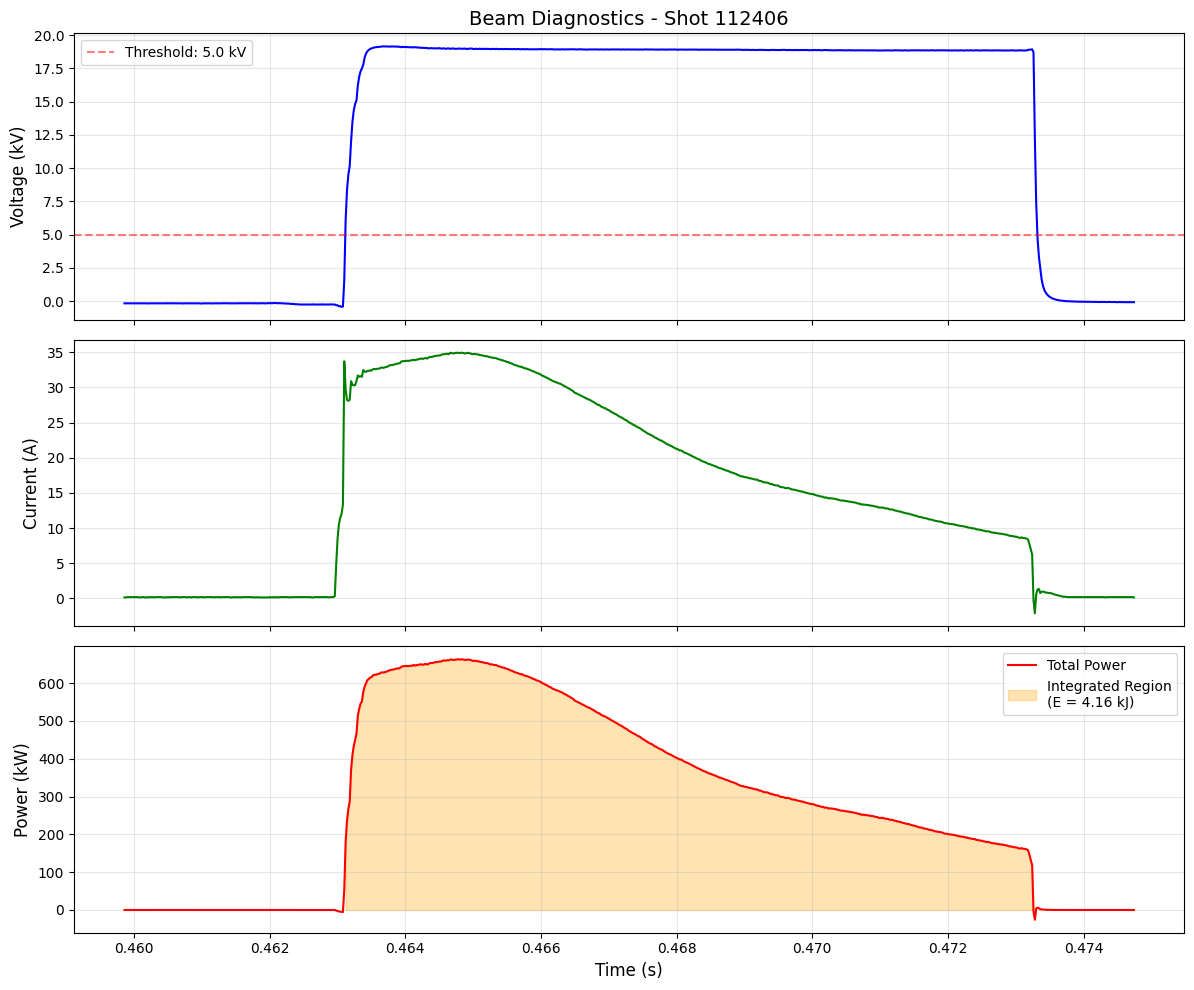


Beam-on duration: 0.0102 s
Average power during beam-on: 408.40 kW
Total energy delivered: 4.16 kJ


In [ ]:
#PLOTTING BEAM VOLTAGE, CURRENT, POWER TO GET BEAM ENERGY


shot = 112406  # Change this to any shot number you want to inspect
v_thresh = 5000.0

# For new shots (>200000) use ltx_nbi tree, for anything less use ltx_b tree
if shot > 200000:
    treename = 'ltx_nbi'
    prefix = ''
else:
    treename = 'ltx_b'
    prefix = '.oper_diags.ltx_nbi'

tree = get_tree_conn(shot, treename=treename)
(ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
(tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')

# Interpolate current to voltage time base
ib = np.interp(tv, ti, ib)
pb = ib * vb / 1000.0  # Power in kW

# Mask for beam-on period (V > 5 kV)
mask = vb > v_thresh

# Calculate total energy
tv_beam = tv[mask]
pb_beam = pb[mask]
total_energy = np.trapz(pb_beam, tv_beam)

# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot voltage
ax1.plot(tv, vb/1000, 'b-', linewidth=1.5)
ax1.axhline(y=v_thresh/1000, color='r', linestyle='--', alpha=0.5, label=f'Threshold: {v_thresh/1000:.1f} kV')
ax1.set_ylabel('Voltage (kV)', fontsize=12)
ax1.set_title(f'Beam Diagnostics - Shot {shot}', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot current
ax2.plot(tv, ib, 'g-', linewidth=1.5)
ax2.set_ylabel('Current (A)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot power
ax3.plot(tv, pb, 'r-', linewidth=1.5, label='Total Power')
ax3.fill_between(tv_beam, 0, pb_beam, alpha=0.3, color='orange', label=f'Integrated Region\n(E = {total_energy:.2f} kJ)')
ax3.set_ylabel('Power (kW)', fontsize=12)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

print(f"\nBeam-on duration: {tv_beam[-1] - tv_beam[0]:.4f} s")
print(f"Average power during beam-on: {np.mean(pb_beam):.2f} kW")
print(f"Total energy delivered: {total_energy:.2f} kJ")


SEGMENT-BY-SEGMENT ANALYSIS

Shot: 112209.txt | Beam Energy: 2.35 kJ
Wire_Label  V_seg_1 (V)  V_seg_2 (V)  ΔV_seg (V)  ΔT_seg (°C)  ΔT_seg/E (°C/kJ)
 w1 (1-14)     0.500643     0.514564    0.013920     6.178871          2.634513
 w2 (14-2)     0.491182     0.510647    0.019465     8.806364          3.754808
 w3 (2-15)     0.517041     0.541254    0.024213    10.406809          4.437197
 w4 (15-3)     0.533439     0.560079    0.026641    11.098047          4.731923
 w5 (3-16)     0.530995     0.557009    0.026015    10.887215          4.642030
 w6 (16-4)     0.487733     0.510768    0.023035    10.495369          4.474957
 w7 (4-17)     0.509621     0.528244    0.018623     8.120658          3.462441
 w8 (17-5)     1.037811     1.066452    0.028641     6.132829          2.614882
 w9 (5-18)     0.531806     0.551968    0.020162     8.425012          3.592210
w10 (18-6)     0.524343     0.548234    0.023890    10.124956          4.317023
w11 (6-19)     0.529784     0.555168    0.025384  

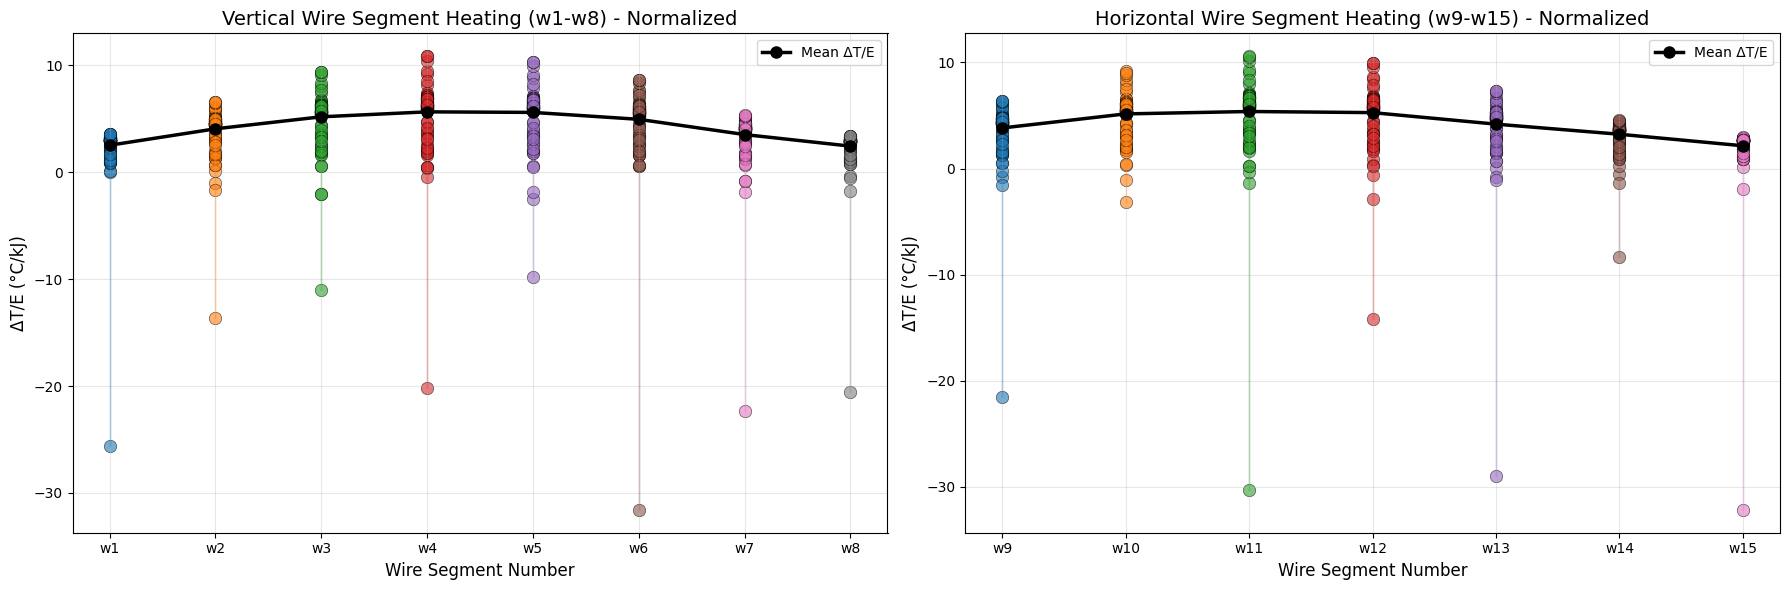



AVERAGE SEGMENT HEATING PER SHOT (across all wire segments)

Shots ranked by Average Segment ΔT (Highest to Lowest):
 Rank       Shot     Avg_ΔT     Std_ΔT     Max_ΔT   Avg_ΔT/E   Beam_E    Beam_V  Beam_On  Beam_Off
    1 112364.txt  24.040563   7.024010  32.762311   5.269873 4.561887 18.639006 0.465654  0.475814
    2 112360.txt  23.840989   6.967837  32.498658   5.221385 4.566028 18.565863 0.463114  0.473314
    3 112361.txt  23.095191   6.741685  31.358435   5.067222 4.557762 18.560723 0.458104  0.468304
    4 112362.txt  22.899511   6.705200  31.381573   5.047755 4.536574 18.540271 0.458111  0.468311
    5 112359.txt  22.371701   6.394299  30.225661   5.104978 4.382330 18.618412 0.463149  0.473309
    6 112545.txt  22.067646   6.111196  29.387634   5.266438 4.190241 18.778605 0.485637  0.495798
    7 112546.txt  21.926389   6.047462  29.191832   5.252996 4.174073 18.765738 0.485621  0.495801
    8 112544.txt  21.598762   6.045924  28.835696   5.198517 4.154793 18.779430 0.485640 

In [ ]:
#SEGMENT ANALYSIS CONTINUED FROM CELL 1 (CHANGE CELL 1 SHOT LIST TO SEE CHANGES HERE)

print("\n" + "="*100)
print("SEGMENT-BY-SEGMENT ANALYSIS")
print("="*100)

# Define segment mappings: (name, high_ch, low_ch, label)
segment_mappings = [
    ('w1', 0, 1, '1-14'),     # w1 = ch0 - ch1
    ('w2', 1, 2, '14-2'),     # w2 = ch1 - ch2
    ('w3', 2, 3, '2-15'),
    ('w4', 3, 4, '15-3'),
    ('w5', 4, 5, '3-16'),
    ('w6', 5, 6, '16-4'),
    ('w7', 6, 7, '4-17'),
    ('w8', 7, 8, '17-5'),     # to center tap
    ('w9', 8, 9, '5-18'),
    ('w10', 9, 10, '18-6'),
    ('w11', 10, 11, '6-19'),
    ('w12', 11, 12, '19-7'),
    ('w13', 12, 13, '7-20'),
    ('w14', 13, 14, '20-8'),
    ('w15', 14, 15, '8-21'),
]

segment_results = []

for shot_file, df in datasets.items():
    shot_num = int(Path(shot_file).stem)
    beam_E = beam_energies[shot_file]
    
    channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"] and "16" not in c]
    
    # Get voltage averages before and after heating
    v1_start, v1_end = 0, 2000      # first 2 seconds
    v2_start, v2_end = 1800, 3800    # 2 seconds starting at t=1.8s
    
    ch_v1 = {}
    ch_v2 = {}
    
    for idx, col in enumerate(channel_cols):
        y = df[col].values
        ch_v1[idx] = np.mean(y[v1_start:v1_end])
        ch_v2[idx] = np.mean(y[v2_start:v2_end])
    
    # Calculate heating for each segment
    for wire, ch_high, ch_low, phys_label in segment_mappings:
        if ch_high not in ch_v1 or ch_low not in ch_v1:
            continue
        
        # Voltage across this segment before and after
        V1 = ch_v1[ch_high] - ch_v1[ch_low]
        V2 = ch_v2[ch_high] - ch_v2[ch_low]
        dV = V2 - V1
        
        # Convert to resistance and temperature
        dR = dV / WIRE_CURRENT
        R1 = V1 / WIRE_CURRENT
        
        dT = dR / (R1 * TCR) if R1 > 0 else np.nan
        dT_norm = dT / beam_E if (not np.isnan(dT) and beam_E > 0) else np.nan
        
        segment_results.append({
            'Shot': shot_file,
            'Wire_Name': wire,
            'Wire_Label': f'{wire} ({phys_label})',
            'Ch_High': ch_high,
            'Ch_Low': ch_low,
            'V_seg_1 (V)': V1,
            'V_seg_2 (V)': V2,
            'ΔV_seg (V)': dV,
            'R_seg_1 (Ω)': R1,
            'ΔR_seg (Ω)': dR,
            'ΔT_seg (°C)': dT,
            'Beam Energy (kJ)': beam_E,
            'ΔT_seg/E (°C/kJ)': dT_norm
        })

segment_df = pd.DataFrame(segment_results)

# Print results for each shot
for shot_file in segment_df['Shot'].unique():
    shot_data = segment_df[segment_df['Shot'] == shot_file]
    energy = shot_data['Beam Energy (kJ)'].iloc[0]
    
    print(f"\n{'='*100}")
    print(f"Shot: {shot_file} | Beam Energy: {energy:.2f} kJ")
    print(f"{'='*100}")
    print(shot_data[['Wire_Label', 'V_seg_1 (V)', 'V_seg_2 (V)', 'ΔV_seg (V)', 
                     'ΔT_seg (°C)', 'ΔT_seg/E (°C/kJ)']].to_string(index=False))

# Calculate stats for plotting
seg_stats = segment_df.groupby(['Wire_Name', 'Wire_Label']).agg({
    'ΔT_seg (°C)': ['mean', 'std', 'min', 'max'],
    'ΔT_seg/E (°C/kJ)': ['mean', 'std', 'min', 'max']
}).reset_index()

seg_stats.columns = ['Wire_Name', 'Wire_Label', 'ΔT_mean', 'ΔT_std', 'ΔT_min', 'ΔT_max',
                     'ΔT/E_mean', 'ΔT/E_std', 'ΔT/E_min', 'ΔT/E_max']

seg_stats['sort_key'] = seg_stats['Wire_Name'].str.extract('(\d+)').astype(int)
seg_stats = seg_stats.sort_values('sort_key').drop('sort_key', axis=1)

# PLOTS: SEGMENT HEATING PROFILES
print("\n\nCreating segment heating plots (normalized by beam energy)...")

all_wires = sorted(segment_df['Wire_Name'].unique(), key=lambda x: int(x[1:]))
vert_wires = [w for w in all_wires if w in ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']]
horiz_wires = [w for w in all_wires if w in ['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Vertical wires
for wire in vert_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    wire_num = int(wire[1:])
    x = np.full(len(data), wire_num)
    y = data['ΔT_seg/E (°C/kJ)'].values
    
    ax1.scatter(x, y, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax1.plot(x, y, alpha=0.3, linewidth=1)

# Mean line for vertical
vert_means, vert_x = [], []
for wire in vert_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    vert_means.append(data['ΔT_seg/E (°C/kJ)'].mean())
    vert_x.append(int(wire[1:]))
ax1.plot(vert_x, vert_means, 'k-', linewidth=2.5, marker='o', markersize=8, label='Mean ΔT/E')

ax1.set_xlabel('Wire Segment Number', fontsize=12)
ax1.set_ylabel('ΔT/E (°C/kJ)', fontsize=12)
ax1.set_title('Vertical Wire Segment Heating (w1-w8) - Normalized', fontsize=14)
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels(['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8'])
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)

# Horizontal wires
for wire in horiz_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    wire_num = int(wire[1:])
    x = np.full(len(data), wire_num)
    y = data['ΔT_seg/E (°C/kJ)'].values
    
    ax2.scatter(x, y, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.plot(x, y, alpha=0.3, linewidth=1)

# Mean line for horizontal
horiz_means, horiz_x = [], []
for wire in horiz_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    horiz_means.append(data['ΔT_seg/E (°C/kJ)'].mean())
    horiz_x.append(int(wire[1:]))
ax2.plot(horiz_x, horiz_means, 'k-', linewidth=2.5, marker='o', markersize=8, label='Mean ΔT/E')

ax2.set_xlabel('Wire Segment Number', fontsize=12)
ax2.set_ylabel('ΔT/E (°C/kJ)', fontsize=12)
ax2.set_title('Horizontal Wire Segment Heating (w9-w15) - Normalized', fontsize=14)
ax2.set_xticks([9, 10, 11, 12, 13, 14, 15])
ax2.set_xticklabels(['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15'])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

# AVG SEGMENT HEATING PER SHOT
print("\n\n" + "="*100)
print("AVERAGE SEGMENT HEATING PER SHOT (across all wire segments)")
print("="*100)

# Average all segments for each shot
shot_avg = segment_df.groupby('Shot').agg({
    'ΔT_seg (°C)': ['mean', 'std', 'min', 'max'],
    'ΔT_seg/E (°C/kJ)': ['mean', 'std', 'min', 'max'],
    'Beam Energy (kJ)': 'first'
}).reset_index()

shot_avg.columns = ['Shot', 'Avg_ΔT', 'Std_ΔT', 'Min_ΔT', 'Max_ΔT',
                    'Avg_ΔT/E', 'Std_ΔT/E', 'Min_ΔT/E', 'Max_ΔT/E', 'Beam_E']

# Add beam timing information
shot_avg['Beam_On'] = shot_avg['Shot'].map(lambda x: beam_timings[x][0])
shot_avg['Beam_Off'] = shot_avg['Shot'].map(lambda x: beam_timings[x][1])

# Add beam voltage information
shot_avg['Beam_V'] = shot_avg['Shot'].map(lambda x: beam_voltages[x])

# Rank by raw heating
by_temp = shot_avg.sort_values('Avg_ΔT', ascending=False).reset_index(drop=True)
by_temp['Rank'] = by_temp.index + 1

print("\nShots ranked by Average Segment ΔT (Highest to Lowest):")
print(by_temp[['Rank', 'Shot', 'Avg_ΔT', 'Std_ΔT', 'Max_ΔT', 'Avg_ΔT/E', 'Beam_E', 'Beam_V', 'Beam_On', 'Beam_Off']].to_string(index=False))

# Rank by normalized heating
by_norm = shot_avg.sort_values('Avg_ΔT/E', ascending=False).reset_index(drop=True)
by_norm['Rank'] = by_norm.index + 1

print("\n\nShots ranked by Average Segment ΔT/E (Highest to Lowest):")
print(by_norm[['Rank', 'Shot', 'Avg_ΔT/E', 'Std_ΔT/E', 'Max_ΔT/E', 'Avg_ΔT', 'Beam_E', 'Beam_V', 'Beam_On', 'Beam_Off']].to_string(index=False))

print("\n" + "="*100)
print("Segment-by-segment analysis complete!")
print("="*100)